In [1]:
import torch
from torch import Tensor
from torch import nn 
from torch.autograd import Variable
import torch.nn.functional as F
import numpy as np
from utility import *

np.random.seed(seed=7)

In [2]:
import dlc_bci

train_input_100 , train_target_100 = dlc_bci.load(root = './data_bci_100Hz', download = False)
test_input_100 , test_target_100 = dlc_bci.load(root = './data_bci_100Hz', download = False, train = False)

train_input_1000 , train_target_1000 = dlc_bci.load(root = './data_bci_1000Hz', download = False, one_khz = True)
test_input_1000 , test_target_1000 = dlc_bci.load(root = './data_bci_1000Hz', download = False, train = False, one_khz = True)

print("Train input 100 Hz: {:d}x{:d}x{:d}".format(*(s for s in train_input_100.size())))
print("Train target 100 Hz: {:d}".format(*(s for s in train_target_100.size())))
print("Test input 100 Hz: {:d}x{:d}x{:d}".format(*(s for s in test_input_100.size())))
print("Test target 100 Hz: {:d}".format(*(s for s in test_target_100.size())))
print("")
print("Train input 1000 Hz: {:d}x{:d}x{:d}".format(*(s for s in train_input_1000.size())))
print("Train target 1000 Hz: {:d}".format(*(s for s in train_target_1000.size())))
print("Test input 1000 Hz: {:d}x{:d}x{:d}".format(*(s for s in test_input_1000.size())))
print("Test target 1000 Hz: {:d}".format(*(s for s in test_target_1000.size())))

Train input 100 Hz: 316x28x50
Train target 100 Hz: 316
Test input 100 Hz: 100x28x50
Test target 100 Hz: 100

Train input 1000 Hz: 316x28x500
Train target 1000 Hz: 316
Test input 1000 Hz: 100x28x500
Test target 1000 Hz: 100


# Network definition

This conv2d network is more inspired from a classic conv2d net that is used for image recognition 

In [3]:
from models import *

# Preprocessing and Data Augmentation

In [4]:
import numpy as np

preprocessed_input_train, preprocessed_input_validation, preprocessed_input_train_target, preprocessed_input_validation_target, kept_channels_idx = preprocessing_train(train_input_1000, train_target_1000, subsampling_frequency='100Hz', window=False,denoize=False, addGaussianNoise=False, reduceChannels=False, cutEnd = False)
preprocessed_input_test, preprocessed_input_test_target  = preprocessing_test(test_input_1000, test_target_1000, kept_channels_idx, subsampling_frequency='100Hz', window=False,denoize = False, reduceChannels=False, cutEnd=False)

#Remove Noise
#preprocessed_input_train = denoisedSignals(preprocessed_input_train)
#preprocessed_input_validation = denoisedSignals(preprocessed_input_validation)
#preprocessed_input_test = denoisedSignals(preprocessed_input_test)
#add random noise
#preprocessed_input_train = whiteNoise(preprocessed_input_train)
#preprocessed_input_validation = whiteNoise(preprocessed_input_validation)
#preprocessed_input_test = whiteNoise(preprocessed_input_test)

print('train', preprocessed_input_train.shape)
print('test', preprocessed_input_test.shape)
print('validation', preprocessed_input_validation.shape)

labels_train = torch.from_numpy(preprocessed_input_train_target)
labels_test = torch.from_numpy(preprocessed_input_test_target)
labels_validation = torch.from_numpy(preprocessed_input_validation_target)

preprocessed_input_train = torch.from_numpy(preprocessed_input_train).float()
preprocessed_input_test = torch.from_numpy(preprocessed_input_test).float()
preprocessed_input_validation = torch.from_numpy(preprocessed_input_validation).float()

Ntrain = len(preprocessed_input_train[:,0,0])
Ntest = len(preprocessed_input_test[:,0,0])
Nvalidation = len(preprocessed_input_validation[:,0,0])

Nchannels = len(preprocessed_input_train[0,:,0])
Nsamples_100 = preprocessed_input_train.size(-1)

print('Ntrain = ', Ntrain)
print('Ntest = ', Ntest)
print('Nvalidation = ', Nvalidation)

train_input = Variable(preprocessed_input_train.view(Ntrain, 1, Nchannels, Nsamples_100))
validation_input = Variable(preprocessed_input_validation.view(Nvalidation, 1, Nchannels, Nsamples_100), requires_grad=False)
test_input = Variable(preprocessed_input_test.contiguous().view(Ntest, 1, Nchannels, Nsamples_100), requires_grad=False)

train (3000, 28, 50)
test (1000, 28, 50)
validation (160, 28, 50)
Ntrain =  3000
Ntest =  1000
Nvalidation =  160


# Network training and testing
Non-linearity: elu  


|criterion | optimizer | lr  | momentum | batch size | Nepochs | Train acc. | Test acc.|
|----------|-----------|-----|----------|------------|---------|------------|----------|
| BCE  | Adam  |1e-1 | def. | 15 | 150 | 86.4 | 61.4 | 
| BCE  | Adam  |1e-1 | def. | 20 | 150 | 99.8 | 79.5 | 
| BCE  | SGD   | 1e-2 | 0.85 | 20 | 150 | 98.9  | 61.5 | 
| CE   | Adam  | 1e-2 | def. | 20 | 150 | 98.4  |  70.5 | 
| CE   | SGD   | 1e-2 | 0.85 | 20 | 150 | 99.1 | 75.1 |


Non-linearity: ReLU

In [5]:
import torch.optim as optim
import math

# Train network 
#criterion = nn.BCELoss()
#criterion = nn.CrossEntropyLoss()
#criterion = nn.PoissonNLLLoss()
#criterion = nn.BCEWithLogitsLoss()
criterion = nn.SmoothL1Loss() #interesting ... but does not converge
#criterion = nn.MSELoss() #0.83 but unstable

if isinstance(criterion, nn.CrossEntropyLoss):
    train_target = Variable(labels_train)  # keep long tensors
    validation_target = Variable(labels_validation, requires_grad=False) # convert to float
    test_target = Variable(labels_test, requires_grad=False)
    Noutputs = 2
    
elif isinstance(criterion, nn.NLLLoss):
    train_target = Variable(labels_train)  # keep long tensors
    validation_target = Variable(labels_validation, requires_grad=False) # convert to float
    test_target = Variable(labels_test, requires_grad=False )
    Noutputs = 2
    
else:
    train_target = Variable(labels_train.float()) # convert to float
    validation_target = Variable(labels_validation.float(), requires_grad=False) # convert to float
    test_target = Variable(labels_test.float(), requires_grad=False)
    Noutputs = 1

batch_size = 15
Nbatches = int(math.ceil(Ntrain/batch_size))
Nepochs = 100
seeds = list(range(10))
#seeds = [14,20,21,22,27,46,44,37,31,28]
Nrep = len(seeds)

train_errors = torch.Tensor(Nrep, Nepochs).zero_()
test_errors = torch.Tensor(Nrep, Nepochs).zero_()
validation_errors = torch.Tensor(Nrep, Nepochs).zero_()
ep_loss = torch.Tensor(Nrep, Nepochs).zero_()

for i_rep in range(Nrep):
    
    print('Repetition', seeds[i_rep])
    torch.manual_seed(seeds[i_rep])
    #model = conv2DNet_1(Noutputs) #from classic knowledge of image segmentation  
    #model = conv2DNet_2(Nchannels, Nsamples_100, Noutputs) #from litterature 
    #model = conv2DNet_3(Noutputs) #from PdM
    #model = conv2DNet_4(Noutputs) #from PdM
    #model = conv2DNet_5(Noutputs)
    #model = conv2DNet_6(Noutputs)
    #model = conv2DNet_7(Noutputs)
    model = conv2DNet_9(Noutputs)
    
    optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=0.50)
    #optimizer = optim.Adam(model.parameters())
    #optimizer = optim.Adagrad(model.parameters())
    #optimizer = optim.Adamax(model.parameters())
    #optimizer = optim.ASGD(model.parameters())
    #optimizer = optim.RMSprop(model.parameters())
    #optimizer = optim.Rprop(model.parameters())
    
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=10, verbose=True)

    for i_ep in range(Nepochs):
        for b_start in range(0, Ntrain, batch_size):
            bsize_eff = batch_size - max(0, b_start+batch_size-Ntrain)  # boundary case
            model.train()
            model.zero_grad()
            output = model.forward(train_input.narrow(0, b_start, bsize_eff))
            if isinstance(criterion, nn.CrossEntropyLoss) or isinstance(criterion, nn.NLLLoss):
                batch_loss = criterion(output, train_target.narrow(0, b_start, bsize_eff))  
            else: 
                batch_loss = criterion(output.view(bsize_eff), train_target.narrow(0, b_start, bsize_eff))           
            ep_loss[i_rep, i_ep] += batch_loss.data[0]
            batch_loss.backward()
            optimizer.step()
        
        scheduler.step(ep_loss[i_rep, i_ep])
        
        nb_train_errs = compute_nb_errors(model, train_input, train_target, batch_size, criterion)
        nb_validation_errs = compute_nb_errors(model, validation_input, validation_target, batch_size, criterion)
        nb_test_errs = compute_nb_errors(model, test_input, test_target, batch_size, criterion)
        
        print("Epoch Number : ", i_ep)
        print("\t Training accuracy: ", (100*(Ntrain-nb_train_errs)/Ntrain))
        print("\t Validation accuracy ",(100*(Nvalidation-nb_validation_errs)/Nvalidation)) 
        print("\t Test accuracy ",(100*(Ntest-nb_test_errs)/Ntest))
        
        print("\t Epoch Loss ", ep_loss[i_rep, i_ep])
        
        train_errors[i_rep, i_ep] = nb_train_errs
        test_errors[i_rep, i_ep] = nb_test_errs
        validation_errors[i_rep, i_ep] = nb_validation_errs

Repetition 0
Epoch Number :  0
	 Training accuracy:  49.0
	 Validation accuracy  62.5
	 Test accuracy  51.0
	 Epoch Loss  25.742708206176758
Epoch Number :  1
	 Training accuracy:  49.0
	 Validation accuracy  62.5
	 Test accuracy  51.0
	 Epoch Loss  25.56103515625
Epoch Number :  2
	 Training accuracy:  49.0
	 Validation accuracy  62.5
	 Test accuracy  51.0
	 Epoch Loss  25.44586944580078
Epoch Number :  3
	 Training accuracy:  49.0
	 Validation accuracy  62.5
	 Test accuracy  50.7
	 Epoch Loss  25.265398025512695
Epoch Number :  4
	 Training accuracy:  50.03333333333333
	 Validation accuracy  62.5
	 Test accuracy  50.3
	 Epoch Loss  25.02370834350586
Epoch Number :  5
	 Training accuracy:  50.6
	 Validation accuracy  62.5
	 Test accuracy  50.0
	 Epoch Loss  24.92839813232422
Epoch Number :  6
	 Training accuracy:  50.333333333333336
	 Validation accuracy  62.5
	 Test accuracy  50.2
	 Epoch Loss  24.91190528869629
Epoch Number :  7
	 Training accuracy:  50.9
	 Validation accuracy  62.5

Epoch Number :  60
	 Training accuracy:  77.36666666666666
	 Validation accuracy  65.625
	 Test accuracy  70.1
	 Epoch Loss  20.024124145507812
Epoch Number :  61
	 Training accuracy:  77.6
	 Validation accuracy  68.75
	 Test accuracy  70.4
	 Epoch Loss  19.97060775756836
Epoch Number :  62
	 Training accuracy:  78.3
	 Validation accuracy  68.75
	 Test accuracy  72.0
	 Epoch Loss  20.07654571533203
Epoch Number :  63
	 Training accuracy:  76.73333333333333
	 Validation accuracy  68.75
	 Test accuracy  69.3
	 Epoch Loss  19.41752052307129
Epoch Number :  64
	 Training accuracy:  78.46666666666667
	 Validation accuracy  62.5
	 Test accuracy  71.2
	 Epoch Loss  19.38434600830078
Epoch Number :  65
	 Training accuracy:  79.03333333333333
	 Validation accuracy  66.875
	 Test accuracy  72.1
	 Epoch Loss  19.17333984375
Epoch Number :  66
	 Training accuracy:  78.9
	 Validation accuracy  67.5
	 Test accuracy  71.4
	 Epoch Loss  19.321683883666992
Epoch Number :  67
	 Training accuracy:  79.96

Epoch Number :  19
	 Training accuracy:  59.333333333333336
	 Validation accuracy  42.5
	 Test accuracy  52.8
	 Epoch Loss  24.117084503173828
Epoch Number :  20
	 Training accuracy:  59.666666666666664
	 Validation accuracy  42.5
	 Test accuracy  52.4
	 Epoch Loss  23.91316795349121
Epoch Number :  21
	 Training accuracy:  60.13333333333333
	 Validation accuracy  41.25
	 Test accuracy  52.3
	 Epoch Loss  24.00145149230957
Epoch Number :  22
	 Training accuracy:  60.63333333333333
	 Validation accuracy  41.875
	 Test accuracy  53.2
	 Epoch Loss  23.946104049682617
Epoch Number :  23
	 Training accuracy:  61.266666666666666
	 Validation accuracy  41.25
	 Test accuracy  54.5
	 Epoch Loss  23.907445907592773
Epoch Number :  24
	 Training accuracy:  61.43333333333333
	 Validation accuracy  43.75
	 Test accuracy  55.0
	 Epoch Loss  23.685720443725586
Epoch Number :  25
	 Training accuracy:  62.43333333333333
	 Validation accuracy  43.125
	 Test accuracy  54.9
	 Epoch Loss  23.74142646789550

Epoch Number :  78
	 Training accuracy:  87.03333333333333
	 Validation accuracy  65.0
	 Test accuracy  72.4
	 Epoch Loss  14.741375923156738
Epoch Number :  79
	 Training accuracy:  87.3
	 Validation accuracy  63.75
	 Test accuracy  72.6
	 Epoch Loss  14.753716468811035
Epoch Number :  80
	 Training accuracy:  87.9
	 Validation accuracy  68.75
	 Test accuracy  73.1
	 Epoch Loss  14.54848575592041
Epoch Number :  81
	 Training accuracy:  87.56666666666666
	 Validation accuracy  68.75
	 Test accuracy  72.9
	 Epoch Loss  14.326623916625977
Epoch Number :  82
	 Training accuracy:  88.36666666666666
	 Validation accuracy  65.0
	 Test accuracy  74.3
	 Epoch Loss  14.012367248535156
Epoch Number :  83
	 Training accuracy:  87.76666666666667
	 Validation accuracy  62.5
	 Test accuracy  73.6
	 Epoch Loss  14.373451232910156
Epoch Number :  84
	 Training accuracy:  87.96666666666667
	 Validation accuracy  62.5
	 Test accuracy  73.3
	 Epoch Loss  14.027650833129883
Epoch Number :  85
	 Training 

Epoch Number :  38
	 Training accuracy:  78.6
	 Validation accuracy  55.625
	 Test accuracy  71.9
	 Epoch Loss  20.395832061767578
Epoch Number :  39
	 Training accuracy:  79.56666666666666
	 Validation accuracy  54.375
	 Test accuracy  72.4
	 Epoch Loss  20.1619930267334
Epoch Number :  40
	 Training accuracy:  80.1
	 Validation accuracy  55.625
	 Test accuracy  75.6
	 Epoch Loss  19.947908401489258
Epoch Number :  41
	 Training accuracy:  80.26666666666667
	 Validation accuracy  56.25
	 Test accuracy  75.3
	 Epoch Loss  19.72161102294922
Epoch Number :  42
	 Training accuracy:  79.63333333333334
	 Validation accuracy  56.25
	 Test accuracy  76.3
	 Epoch Loss  19.5063419342041
Epoch Number :  43
	 Training accuracy:  82.06666666666666
	 Validation accuracy  55.625
	 Test accuracy  75.8
	 Epoch Loss  19.453609466552734
Epoch Number :  44
	 Training accuracy:  82.63333333333334
	 Validation accuracy  49.375
	 Test accuracy  75.1
	 Epoch Loss  19.432435989379883
Epoch Number :  45
	 Trai

Epoch Number :  98
	 Training accuracy:  90.53333333333333
	 Validation accuracy  71.25
	 Test accuracy  79.5
	 Epoch Loss  13.192384719848633
Epoch Number :  99
	 Training accuracy:  89.96666666666667
	 Validation accuracy  71.875
	 Test accuracy  79.7
	 Epoch Loss  13.405928611755371
Repetition 3
Epoch Number :  0
	 Training accuracy:  51.1
	 Validation accuracy  37.5
	 Test accuracy  49.0
	 Epoch Loss  25.43412971496582
Epoch Number :  1
	 Training accuracy:  51.13333333333333
	 Validation accuracy  37.5
	 Test accuracy  48.9
	 Epoch Loss  25.35072898864746
Epoch Number :  2
	 Training accuracy:  51.233333333333334
	 Validation accuracy  37.5
	 Test accuracy  48.9
	 Epoch Loss  25.305233001708984
Epoch Number :  3
	 Training accuracy:  51.333333333333336
	 Validation accuracy  37.5
	 Test accuracy  48.9
	 Epoch Loss  25.301776885986328
Epoch Number :  4
	 Training accuracy:  51.233333333333334
	 Validation accuracy  37.5
	 Test accuracy  49.0
	 Epoch Loss  25.26601791381836
Epoch Nu

Epoch Number :  57
	 Training accuracy:  78.6
	 Validation accuracy  62.5
	 Test accuracy  77.8
	 Epoch Loss  20.3950138092041
Epoch Number :  58
	 Training accuracy:  77.63333333333334
	 Validation accuracy  56.25
	 Test accuracy  76.3
	 Epoch Loss  20.144878387451172
Epoch Number :  59
	 Training accuracy:  79.4
	 Validation accuracy  61.875
	 Test accuracy  77.5
	 Epoch Loss  20.149383544921875
Epoch Number :  60
	 Training accuracy:  79.4
	 Validation accuracy  58.125
	 Test accuracy  78.4
	 Epoch Loss  19.758594512939453
Epoch Number :  61
	 Training accuracy:  79.46666666666667
	 Validation accuracy  56.25
	 Test accuracy  78.7
	 Epoch Loss  20.244773864746094
Epoch Number :  62
	 Training accuracy:  79.56666666666666
	 Validation accuracy  60.625
	 Test accuracy  79.6
	 Epoch Loss  19.44146156311035
Epoch Number :  63
	 Training accuracy:  80.1
	 Validation accuracy  60.0
	 Test accuracy  79.0
	 Epoch Loss  19.632001876831055
Epoch Number :  64
	 Training accuracy:  80.1
	 Valid

Epoch Number :  17
	 Training accuracy:  55.2
	 Validation accuracy  36.875
	 Test accuracy  45.7
	 Epoch Loss  24.84263038635254
Epoch Number :  18
	 Training accuracy:  55.333333333333336
	 Validation accuracy  36.875
	 Test accuracy  44.8
	 Epoch Loss  24.769533157348633
Epoch Number :  19
	 Training accuracy:  55.4
	 Validation accuracy  37.5
	 Test accuracy  43.2
	 Epoch Loss  24.898588180541992
Epoch Number :  20
	 Training accuracy:  55.6
	 Validation accuracy  37.5
	 Test accuracy  42.8
	 Epoch Loss  24.809093475341797
Epoch Number :  21
	 Training accuracy:  56.03333333333333
	 Validation accuracy  37.5
	 Test accuracy  42.5
	 Epoch Loss  24.756284713745117
Epoch Number :  22
	 Training accuracy:  56.333333333333336
	 Validation accuracy  37.5
	 Test accuracy  42.5
	 Epoch Loss  24.720996856689453
Epoch Number :  23
	 Training accuracy:  56.86666666666667
	 Validation accuracy  37.5
	 Test accuracy  42.6
	 Epoch Loss  24.73406219482422
Epoch Number :  24
	 Training accuracy:  

Epoch Number :  77
	 Training accuracy:  79.23333333333333
	 Validation accuracy  66.875
	 Test accuracy  72.7
	 Epoch Loss  20.21061134338379
Epoch Number :  78
	 Training accuracy:  79.4
	 Validation accuracy  70.625
	 Test accuracy  71.7
	 Epoch Loss  20.158924102783203
Epoch Number :  79
	 Training accuracy:  79.6
	 Validation accuracy  55.625
	 Test accuracy  73.6
	 Epoch Loss  19.88370704650879
Epoch Number :  80
	 Training accuracy:  80.8
	 Validation accuracy  62.5
	 Test accuracy  74.6
	 Epoch Loss  20.001562118530273
Epoch Number :  81
	 Training accuracy:  79.96666666666667
	 Validation accuracy  59.375
	 Test accuracy  73.7
	 Epoch Loss  19.530439376831055
Epoch Number :  82
	 Training accuracy:  80.73333333333333
	 Validation accuracy  58.125
	 Test accuracy  73.9
	 Epoch Loss  19.592653274536133
Epoch Number :  83
	 Training accuracy:  80.23333333333333
	 Validation accuracy  69.375
	 Test accuracy  72.1
	 Epoch Loss  19.68856430053711
Epoch Number :  84
	 Training accura

Epoch Number :  37
	 Training accuracy:  61.7
	 Validation accuracy  46.25
	 Test accuracy  43.1
	 Epoch Loss  24.28441619873047
Epoch Number :  38
	 Training accuracy:  61.43333333333333
	 Validation accuracy  42.5
	 Test accuracy  43.5
	 Epoch Loss  24.340396881103516
Epoch Number :  39
	 Training accuracy:  61.86666666666667
	 Validation accuracy  43.75
	 Test accuracy  44.1
	 Epoch Loss  24.238067626953125
Epoch Number :  40
	 Training accuracy:  61.9
	 Validation accuracy  43.75
	 Test accuracy  44.3
	 Epoch Loss  24.201854705810547
Epoch Number :  41
	 Training accuracy:  62.46666666666667
	 Validation accuracy  43.75
	 Test accuracy  44.0
	 Epoch Loss  24.280366897583008
Epoch Number :  42
	 Training accuracy:  62.46666666666667
	 Validation accuracy  40.625
	 Test accuracy  44.1
	 Epoch Loss  24.278249740600586
Epoch Number :  43
	 Training accuracy:  62.7
	 Validation accuracy  43.125
	 Test accuracy  43.9
	 Epoch Loss  24.127283096313477
Epoch Number :  44
	 Training accuracy

Epoch Number :  97
	 Training accuracy:  79.7
	 Validation accuracy  63.125
	 Test accuracy  67.0
	 Epoch Loss  19.882837295532227
Epoch Number :  98
	 Training accuracy:  78.96666666666667
	 Validation accuracy  52.5
	 Test accuracy  69.8
	 Epoch Loss  19.786455154418945
Epoch Number :  99
	 Training accuracy:  79.9
	 Validation accuracy  56.25
	 Test accuracy  66.3
	 Epoch Loss  19.614622116088867
Repetition 6
Epoch Number :  0
	 Training accuracy:  51.06666666666667
	 Validation accuracy  37.5
	 Test accuracy  49.0
	 Epoch Loss  25.75431251525879
Epoch Number :  1
	 Training accuracy:  51.166666666666664
	 Validation accuracy  37.5
	 Test accuracy  48.9
	 Epoch Loss  25.66454315185547
Epoch Number :  2
	 Training accuracy:  51.2
	 Validation accuracy  37.5
	 Test accuracy  48.8
	 Epoch Loss  25.575929641723633
Epoch Number :  3
	 Training accuracy:  51.233333333333334
	 Validation accuracy  37.5
	 Test accuracy  48.6
	 Epoch Loss  25.397218704223633
Epoch Number :  4
	 Training accu

Epoch Number :  57
	 Training accuracy:  73.83333333333333
	 Validation accuracy  46.875
	 Test accuracy  54.5
	 Epoch Loss  21.947547912597656
Epoch Number :  58
	 Training accuracy:  73.7
	 Validation accuracy  48.125
	 Test accuracy  52.2
	 Epoch Loss  22.077396392822266
Epoch Number :  59
	 Training accuracy:  74.1
	 Validation accuracy  45.625
	 Test accuracy  51.5
	 Epoch Loss  22.236921310424805
Epoch Number :  60
	 Training accuracy:  74.16666666666667
	 Validation accuracy  50.0
	 Test accuracy  54.4
	 Epoch Loss  21.921403884887695
Epoch Number :  61
	 Training accuracy:  74.83333333333333
	 Validation accuracy  51.25
	 Test accuracy  54.3
	 Epoch Loss  22.027183532714844
Epoch Number :  62
	 Training accuracy:  72.73333333333333
	 Validation accuracy  40.625
	 Test accuracy  54.1
	 Epoch Loss  21.595252990722656
Epoch Number :  63
	 Training accuracy:  75.73333333333333
	 Validation accuracy  50.625
	 Test accuracy  56.2
	 Epoch Loss  21.840436935424805
Epoch Number :  64
	 

Epoch Number :  18
	 Training accuracy:  51.0
	 Validation accuracy  37.5
	 Test accuracy  49.0
	 Epoch Loss  25.157211303710938
Epoch Number :  19
	 Training accuracy:  51.0
	 Validation accuracy  37.5
	 Test accuracy  49.0
	 Epoch Loss  25.02716636657715
Epoch Number :  20
	 Training accuracy:  51.0
	 Validation accuracy  37.5
	 Test accuracy  49.0
	 Epoch Loss  25.156452178955078
Epoch Number :  21
	 Training accuracy:  51.0
	 Validation accuracy  37.5
	 Test accuracy  49.0
	 Epoch Loss  25.027591705322266
Epoch Number :  22
	 Training accuracy:  51.0
	 Validation accuracy  37.5
	 Test accuracy  49.0
	 Epoch Loss  25.012474060058594
Epoch Number :  23
	 Training accuracy:  51.0
	 Validation accuracy  37.5
	 Test accuracy  49.0
	 Epoch Loss  24.905771255493164
Epoch Number :  24
	 Training accuracy:  51.0
	 Validation accuracy  37.5
	 Test accuracy  49.0
	 Epoch Loss  24.872705459594727
Epoch Number :  25
	 Training accuracy:  51.0
	 Validation accuracy  37.5
	 Test accuracy  49.0
	 

Epoch Number :  79
	 Training accuracy:  64.66666666666667
	 Validation accuracy  35.625
	 Test accuracy  44.4
	 Epoch Loss  22.76339340209961
Epoch Number :  80
	 Training accuracy:  65.0
	 Validation accuracy  35.0
	 Test accuracy  44.3
	 Epoch Loss  22.894229888916016
Epoch Number :  81
	 Training accuracy:  65.46666666666667
	 Validation accuracy  36.875
	 Test accuracy  44.1
	 Epoch Loss  22.582664489746094
Epoch Number :  82
	 Training accuracy:  70.53333333333333
	 Validation accuracy  43.125
	 Test accuracy  43.7
	 Epoch Loss  22.6612548828125
Epoch Number :  83
	 Training accuracy:  70.73333333333333
	 Validation accuracy  42.5
	 Test accuracy  44.9
	 Epoch Loss  22.5139217376709
Epoch Number :  84
	 Training accuracy:  71.5
	 Validation accuracy  43.125
	 Test accuracy  44.8
	 Epoch Loss  22.604286193847656
Epoch Number :  85
	 Training accuracy:  71.23333333333333
	 Validation accuracy  42.5
	 Test accuracy  45.7
	 Epoch Loss  22.334293365478516
Epoch Number :  86
	 Training

Epoch Number :  39
	 Training accuracy:  59.63333333333333
	 Validation accuracy  46.25
	 Test accuracy  45.5
	 Epoch Loss  24.432653427124023
Epoch Number :  40
	 Training accuracy:  59.63333333333333
	 Validation accuracy  48.125
	 Test accuracy  45.1
	 Epoch Loss  24.497661590576172
Epoch Number :  41
	 Training accuracy:  60.2
	 Validation accuracy  48.75
	 Test accuracy  45.5
	 Epoch Loss  24.54303550720215
Epoch Number :  42
	 Training accuracy:  60.53333333333333
	 Validation accuracy  49.375
	 Test accuracy  45.6
	 Epoch Loss  24.536802291870117
Epoch Number :  43
	 Training accuracy:  60.9
	 Validation accuracy  50.0
	 Test accuracy  46.9
	 Epoch Loss  24.499528884887695
Epoch Number :  44
	 Training accuracy:  61.0
	 Validation accuracy  53.125
	 Test accuracy  46.9
	 Epoch Loss  24.47777557373047
Epoch Number :  45
	 Training accuracy:  61.53333333333333
	 Validation accuracy  53.125
	 Test accuracy  47.1
	 Epoch Loss  24.44858169555664
Epoch Number :  46
	 Training accuracy

Epoch Number :  99
	 Training accuracy:  81.5
	 Validation accuracy  66.875
	 Test accuracy  69.3
	 Epoch Loss  20.71988868713379
Repetition 9
Epoch Number :  0
	 Training accuracy:  51.0
	 Validation accuracy  62.5
	 Test accuracy  51.9
	 Epoch Loss  25.205678939819336
Epoch Number :  1
	 Training accuracy:  51.36666666666667
	 Validation accuracy  61.875
	 Test accuracy  51.9
	 Epoch Loss  25.08571434020996
Epoch Number :  2
	 Training accuracy:  52.03333333333333
	 Validation accuracy  60.625
	 Test accuracy  51.6
	 Epoch Loss  25.046401977539062
Epoch Number :  3
	 Training accuracy:  52.43333333333333
	 Validation accuracy  59.375
	 Test accuracy  50.5
	 Epoch Loss  25.095443725585938
Epoch Number :  4
	 Training accuracy:  52.666666666666664
	 Validation accuracy  57.5
	 Test accuracy  50.0
	 Epoch Loss  24.988998413085938
Epoch Number :  5
	 Training accuracy:  53.333333333333336
	 Validation accuracy  56.25
	 Test accuracy  50.2
	 Epoch Loss  24.985986709594727
Epoch Number :  

Epoch Number :  59
	 Training accuracy:  68.7
	 Validation accuracy  46.25
	 Test accuracy  50.7
	 Epoch Loss  23.102224349975586
Epoch Number :  60
	 Training accuracy:  69.2
	 Validation accuracy  48.125
	 Test accuracy  51.9
	 Epoch Loss  23.029985427856445
Epoch Number :  61
	 Training accuracy:  69.56666666666666
	 Validation accuracy  50.0
	 Test accuracy  52.2
	 Epoch Loss  23.052509307861328
Epoch Number :  62
	 Training accuracy:  70.4
	 Validation accuracy  51.25
	 Test accuracy  52.3
	 Epoch Loss  22.920286178588867
Epoch Number :  63
	 Training accuracy:  70.43333333333334
	 Validation accuracy  51.875
	 Test accuracy  52.4
	 Epoch Loss  22.697322845458984
Epoch Number :  64
	 Training accuracy:  70.86666666666666
	 Validation accuracy  51.25
	 Test accuracy  53.0
	 Epoch Loss  22.673662185668945
Epoch Number :  65
	 Training accuracy:  72.03333333333333
	 Validation accuracy  50.625
	 Test accuracy  53.2
	 Epoch Loss  22.578386306762695
Epoch Number :  66
	 Training accura

torch.Size([10, 100])
0


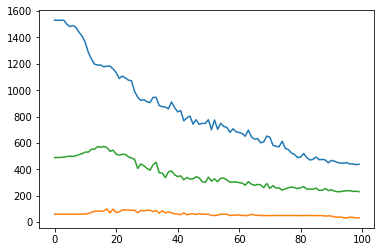

1


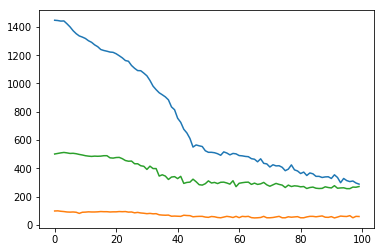

2


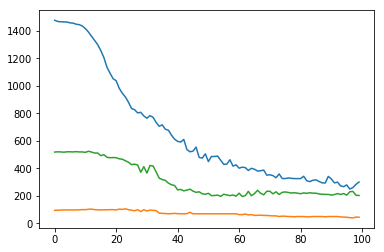

3


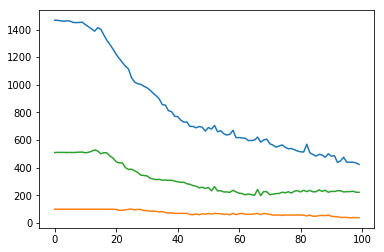

4


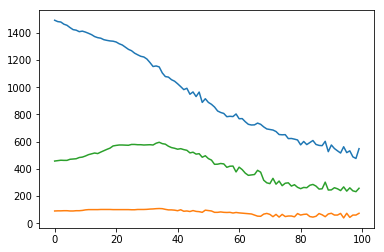

5


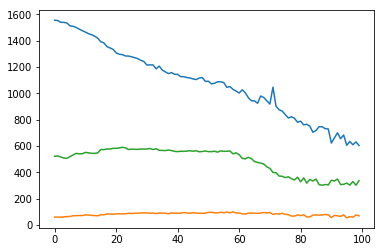

6


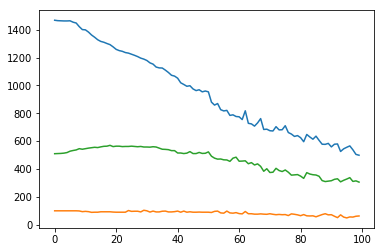

7


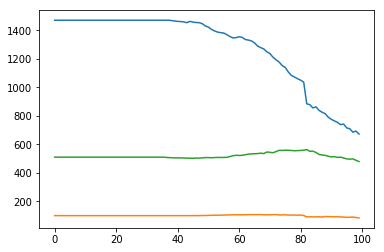

8


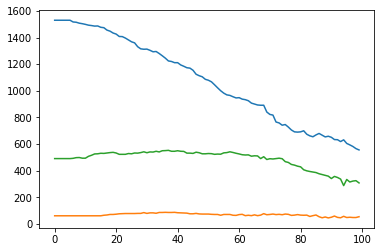

9


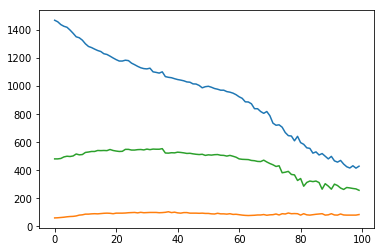

In [6]:
print(train_errors.shape)

for i_rep in range(Nrep):
    print(i_rep)
    plt.plot(np.array(train_errors[i_rep, :]))
    plt.plot(np.array(validation_errors[i_rep, :]))
    plt.plot(np.array(test_errors[i_rep, :]))
    plt.show()

0


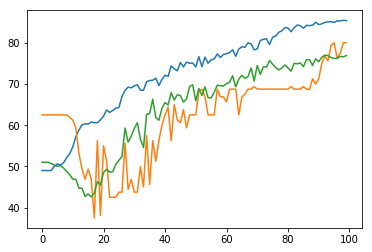

1


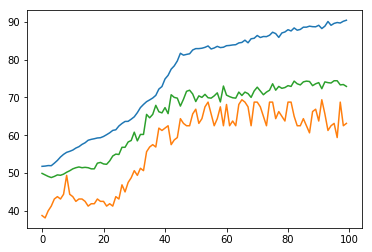

2


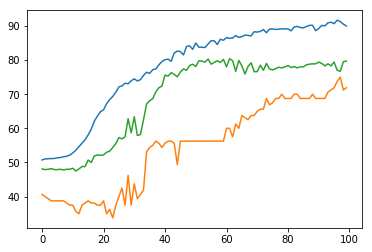

3


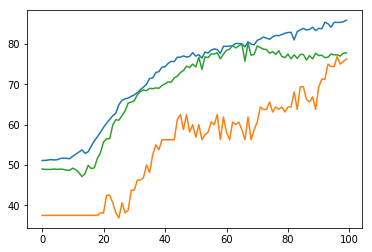

4


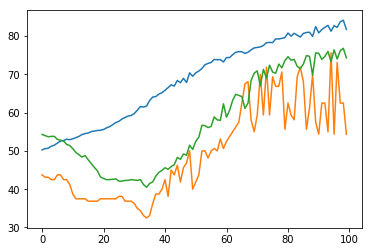

5


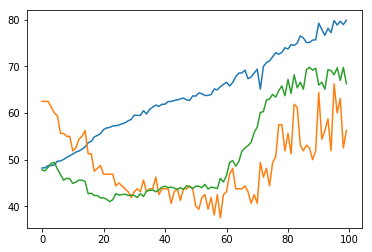

6


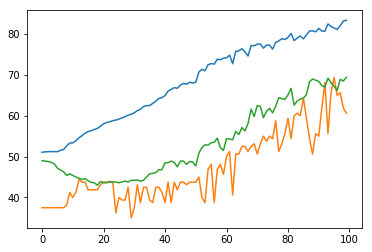

7


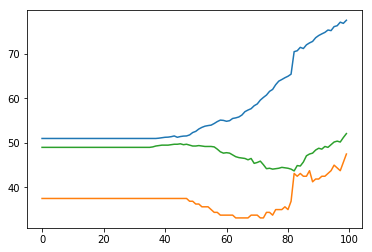

8


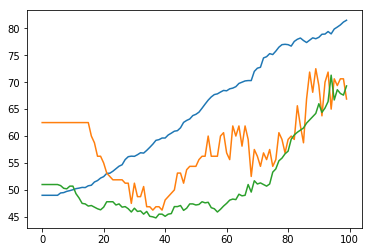

9


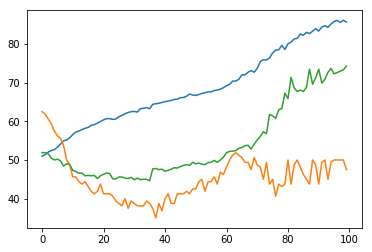

In [7]:
for i_rep in range(Nrep):
    print(i_rep)
    plt.plot(100*(Ntrain-np.array(train_errors[i_rep, :]))/Ntrain)
    plt.plot(100*(Nvalidation-np.array(validation_errors[i_rep, :]))/Nvalidation)
    plt.plot(100*(Ntest-np.array(test_errors[i_rep, :]))/Ntest)

    plt.show()

(100,)
Training accuracy 84.1%+-3.926401138305664
Validation accuracy 62.4%+-10.776311874389648
Testing accuracy 71.3%+-7.52316427230835


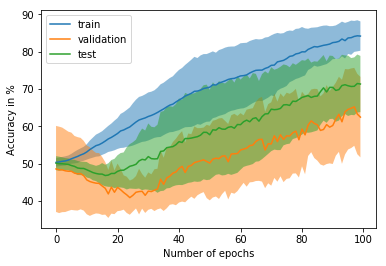

In [8]:
train_accuracy = 100*(Ntrain-np.array(train_errors))/Ntrain
val_accuracy = 100*(Nvalidation-np.array(validation_errors))/Nvalidation
test_accuracy = 100*(Ntest-np.array(test_errors))/Ntest

stddev_train_errors = np.std(train_accuracy, axis=0)
stddev_val_errors = np.std(val_accuracy, axis=0)
stddev_test_errors = np.std(test_accuracy, axis=0)

mean_train_errors = np.mean(train_accuracy, axis=0)
mean_val_errors = np.mean(val_accuracy, axis=0)
mean_test_errors = np.mean(test_accuracy, axis=0)

epoch = list(range(100))
print(stddev_train_errors.shape)

#plt.errorbar(epoch, mean_train_errors, stddev_train_errors)
#plt.errorbar(epoch, mean_val_errors, stddev_val_errors)
#plt.errorbar(epoch, mean_test_errors, stddev_test_errors)

plt.plot(epoch, mean_train_errors)
plt.plot(epoch, mean_val_errors)
plt.plot(epoch, mean_test_errors)
plt.fill_between(epoch, mean_train_errors+stddev_train_errors, mean_train_errors-stddev_train_errors, alpha=0.5)
plt.fill_between(epoch, mean_val_errors+stddev_val_errors, mean_val_errors-stddev_val_errors, alpha=0.5)
plt.fill_between(epoch, mean_test_errors+stddev_test_errors, mean_test_errors-stddev_test_errors, alpha=0.5)
plt.xlabel('Number of epochs')
plt.ylabel('Accuracy in %')
plt.legend(['train', 'validation', 'test'])

print("Training accuracy {:4.3g}%+-{}".format(mean_train_errors[-1], stddev_train_errors[-1]))
print("Validation accuracy {:4.3g}%+-{}".format(mean_val_errors[-1], stddev_val_errors[-1]))
print("Testing accuracy {:4.3g}%+-{}".format(mean_test_errors[-1], stddev_test_errors[-1]))